In [1]:
#imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, sampler
import torchvision
from torchvision import transforms
import albumentations as A
from PIL import Image
import numpy as np
import pandas as pd
from sklearn import metrics
from tqdm import tqdm
import os
from albumentations.pytorch import ToTensorV2
from utils import calc_metric, write_results,list_to_cuda, eval_model, train_one_epoch
from fusion_layer import FusionLayer 
from torchvision.models import resnet18, ResNet18_Weights


INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.10 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:
def get_data_transforms():
    """
    Returns proper data augmentation for the method given as parameter.
    """
    
    #mean and std from pretrained model on imagenet
    mean = [0.485, 0.456, 0.406]
    std = [0.228, 0.224, 0.225]
    
    normalize = A.Normalize(mean=mean, std=std)
    #albumentations on training data
    train_trans = [
                  A.HorizontalFlip(),
                  A.VerticalFlip(), 
                  A.Rotate(),
                  A.ColorJitter(hue=0.2),
                  A.RandomResizedCrop(size=(299,299), scale=(0.75, 1.0)), 
                  A.RandomToneCurve (scale=0.5, p=0.5),
                  normalize,
                  ToTensorV2()]
    #albumentations on validation data
    val_trans =  [
                  A.Resize(height=299, width=299),
                  normalize,
                  ToTensorV2()]
    #albumentations on testing data
    test_trans =  [ 
                   A.Resize(height=299, width=299),
                   normalize,
                   ToTensorV2()]

    #dict to store the transformations for each step
    data_transforms = {
        'train': A.Compose(train_trans),
        'val': A.Compose(val_trans),
        'test': A.Compose(test_trans),
    }
    
    return data_transforms

In [3]:
class PADDataset(torch.utils.data.Dataset):
    def __init__(self, imgs_folder, labels_csv, prefix=None, transforms=None):
        super(PADDataset, self).__init__()
        self.imgs_folder = imgs_folder
        self.img_names= list(os.listdir(self.imgs_folder))
        self.labels_csv = labels_csv
        self.augmentations = transforms

        self.prefix = prefix 
        print(labels_csv)
        self.csv = pd.read_csv(labels_csv,index_col=False) 
        self.csv.reset_index(drop=True, inplace=True)
        
        self.class_counts = dict(self.csv['label'].value_counts())
    

        classes = list(self.csv['label'].unique())
        classes.sort()
        self.class_to_idx = {classes[i]: i for i in range(len(classes))}
        self.classes = classes

        print('Found {} images from {} classes.'.format(len(self.csv),
                                                        len(classes)))
        for class_name, idx in self.class_to_idx.items():
            n_images = dict(self.csv['label'].value_counts())
            print("    Class '{}' ({}): {} images.".format(
                class_name, idx, n_images[class_name]))
    
    def __len__(self):
        """
        returns the length of the dataframe
        """
        return len(self.csv['image'])
    
    def __getitem__(self, idx):
        """
        returns the image, appropriate metadata, and disease label in the row specified by idx
        """
        img_file_name = list(self.csv['image'])[idx]
        img_path = os.path.join(self.imgs_folder, img_file_name)
        img = Image.open(img_path).convert("RGB")

        #Extracting metadata features
        label = torch.tensor(int(list(self.csv['label'])[idx]))
        sk = list(self.csv['skin_cancer_history'])[idx]
        skin_cancer_history =  torch.tensor(int(sk))
        gen = list(self.csv['gender'])[idx]
        gen =  torch.tensor(int(gen))
        fp = list(self.csv['fitspatrick'])[idx]
        fp =  torch.tensor(int(fp))
        elevation = list(self.csv['elevation'])[idx]
        elevation =  torch.tensor(int(elevation))
        changed = list(self.csv['changed'])[idx]
        changed =  torch.tensor(int(changed))
        region = list(self.csv['region'])[idx]
        region =  torch.tensor(int(region))

        if self.augmentations is not None:
            img = self.augmentations(image=np.array(img))["image"]

            
        skin_cancer_history =  torch.tensor(skin_cancer_history)
        gen =  torch.tensor(int(gen))
        fp =  torch.tensor(int(fp))
        elevation =  torch.tensor(int(elevation))
        changed =  torch.tensor(int(changed))
        region =  torch.tensor(int(region))          
        metadata = (skin_cancer_history, gen, fp,elevation,changed,region)
        return img, metadata, label    


In [4]:
data_transforms = get_data_transforms()
batch_size = 32
batch_size_test = 32
lr = 0.0001 





#Creating train validation and test sets, change path accordingly for each cross validation split
ds_path_pad= 'C:\\Users\\preet\\Documents\\skin\\datasets\\pad_ufes_20'
labels_path_train='C:\\Users\\preet\\Documents\\skin\\datasets\\pad_ufes_20\\trn_75_5.csv'
labels_path_val='C:\\Users\\preet\\Documents\\skin\\datasets\\pad_ufes_20\\val_10_5.csv'

labels_path_test='C:\\Users\\preet\\Documents\\skin\\datasets\\pad_ufes_20\\test_15.csv'

pad_train_ds  = PADDataset(imgs_folder=ds_path_pad, labels_csv=labels_path_train, transforms=data_transforms['train'])
pad_test_ds  = PADDataset(imgs_folder=ds_path_pad, labels_csv=labels_path_test, transforms=data_transforms['test'])
pad_val_ds  = PADDataset(imgs_folder=ds_path_pad, labels_csv=labels_path_val, transforms=data_transforms['val'])

#Creating the dataloaders
train_sampler = None
train_loader = DataLoader(pad_train_ds, batch_size=batch_size, shuffle=train_sampler is None,
                          pin_memory=True, num_workers=0, sampler=train_sampler)

val_loader = DataLoader(pad_val_ds, batch_size=batch_size, shuffle=False,
                          pin_memory=True, num_workers=0)

test_loader = DataLoader(pad_test_ds, batch_size=batch_size, shuffle=False,
                          pin_memory=True, num_workers=0)


#Models

#Baseline approach (no metadata information)
class resnet_model(torch.nn.Module):
    def __init__(self):
        super(resnet_model, self).__init__()
        self.encoder =resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
        self.encoder.fc = nn.Linear(self.encoder.fc.in_features,2048)
        self.classifier = nn.Linear(2048, 6)

    def forward(self, x, x_metadata):
        x=self.encoder(x)
        y= self.classifier(x)
        return y
        
#concatenation approach    
class resnet_concat_model(torch.nn.Module):
    def __init__(self):
        super(resnet_concat_model, self).__init__()
        self.encoder =resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
        self.encoder.fc = nn.Linear(self.encoder.fc.in_features,2048)
        #TODO: parametrize this. RESNET -> 2 classes
        self.skin_cancer_emb = nn.Embedding(3, 16)
        self.gender_emb = nn.Embedding(3, 16)
        self.fp_emb = nn.Embedding(7, 16)
        self.elevation_emb = nn.Embedding(3, 16)
        self.change_emb = nn.Embedding(3, 16)
        self.region_emb = nn.Embedding(14, 16)
        self.classifier = nn.Linear(2048+6*16, 6)
 

    def forward(self, x, x_metadata):
        (skin_cancer, gender, fp,elevation,changed,region) = x_metadata
        x=self.encoder(x)
        x1 = self.skin_cancer_emb(skin_cancer)
        x2 = self.gender_emb(gender)
        x3 = self.fp_emb(fp)
        x4 = self.elevation_emb(elevation)
        x5 = self.change_emb(changed)
        x6 = self.region_emb(region)
        x_all = torch.cat((x,x1,x2,x3,x3,x5,x6),dim=1)
        y = self.classifier(x_all)
        return y
        
#Metanet architecture
class resnet_metanet_model(torch.nn.Module):
    def __init__(self, enable_gates=False):
        super(resnet_metanet_model, self).__init__()
        self.encoder =resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
        self.encoder.fc = nn.Linear(self.encoder.fc.in_features,2048)
        self.linear = nn.Linear(3+3+7+3+3+14,2048)
        self.classifier = nn.Linear(2048, 6)
        self.enable_gates = enable_gates
        
    def forward(self, x, x_metadata):
        (skin_cancer, gender, fp,elevation,changed,region) = x_metadata
        x=self.encoder(x)
        skin_cancer = torch.nn.functional.one_hot(skin_cancer, num_classes=3)
        gender = torch.nn.functional.one_hot(gender, num_classes=3)
        fp = torch.nn.functional.one_hot(fp, num_classes=7)
        elevation = torch.nn.functional.one_hot(elevation, num_classes=3)
        changed = torch.nn.functional.one_hot(changed, num_classes=3)
        region = torch.nn.functional.one_hot(region, num_classes=14)
        x_meta = torch.cat((skin_cancer,gender,fp,elevation,changed,region),dim=1)
        y = self.linear(x_meta.float())
        y = F.sigmoid(y)
        x = x*y
        y= self.classifier(x)
        return y

#Metablock architecture
class resnet_metablock_model(torch.nn.Module):
    def __init__(self, enable_gates=False):
        super(resnet_metablock_model, self).__init__()
        self.encoder =resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
        self.encoder.fc = nn.Linear(self.encoder.fc.in_features,2048)
        self.linear1 = nn.Linear(3+3+7+3+3+14,2048)
        self.linear2 = nn.Linear(3+3+7+3+3+14,2048)
        self.classifier = nn.Linear(2048, 6)
        self.enable_gates = enable_gates
        
    def forward(self, x, x_metadata):
        (skin_cancer, gender, fp,elevation,changed,region) = x_metadata
        x=self.encoder(x)
        skin_cancer = torch.nn.functional.one_hot(skin_cancer, num_classes=3)
        gender = torch.nn.functional.one_hot(gender, num_classes=3)
        fp = torch.nn.functional.one_hot(fp, num_classes=7)
        elevation = torch.nn.functional.one_hot(elevation, num_classes=3)
        changed = torch.nn.functional.one_hot(changed, num_classes=3)
        region = torch.nn.functional.one_hot(region, num_classes=14)
        x_meta = torch.cat((skin_cancer,gender,fp,elevation,changed,region),dim=1)
        y1 = self.linear1(x_meta.float())
        y2 = self.linear2(x_meta.float())
        x = F.sigmoid(F.tanh(x*y1)+y2)
        y= self.classifier(x)
        return y

#Metafusion novel approach
class meta_fusion_model(torch.nn.Module):
    def __init__(self):
        super(meta_fusion_model, self).__init__()
        self.encoder =resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
        self.encoder.fc = nn.Linear(self.encoder.fc.in_features,2048)
        self.skin_cancer_emb = nn.Embedding(3, 16)
        self.gender_emb = nn.Embedding(3, 16)
        self.fp_emb = nn.Embedding(7, 16)
        self.elevation_emb = nn.Embedding(3, 16)
        self.change_emb = nn.Embedding(3, 16)
        self.region_emb = nn.Embedding(14, 16)
        self.linear1 = nn.Linear(6*16,6*16)
        self.classifier = nn.Linear(2048+6*16, 6)
        
        self.skin_cancer_gate1 = FusionLayer(16, 2048)
        self.gender_gate1 = FusionLayer(16, 2048)
        self.fp_gate1 = FusionLayer(16, 2048)
        self.elevation_gate1 = FusionLayer(16, 2048)
        self.change_gate1 = FusionLayer(16, 2048)
        self.region_gate1 = FusionLayer(16, 2048)
        self.image_gate1 = FusionLayer(2048, 16*6)  
  
    def forward(self, x, x_metadata):
        (skin_cancer, gender, fp,elevation,changed,region) = x_metadata
        x=self.encoder(x)
        x_skin_cancer = self.skin_cancer_emb(skin_cancer)
        x_gender = self.gender_emb(gender)
        x_fp = self.fp_emb(fp)
        x_elev = self.elevation_emb(elevation)
        x_change = self.change_emb(changed)
        x_region= self.region_emb(region)
        #modify metadata
        x_all = torch.cat((x_skin_cancer,x_gender,x_fp,x_elev,x_change,x_region),dim=1)
        x_all = x_all + self.image_gate1(x_all,x)
        
        #modify image
        x1 = x + self.skin_cancer_gate1(x, x_skin_cancer)
        x2 = x1 + self.gender_gate1(x, x_gender)
        x3 = x2 + self.fp_gate1(x, x_fp)
        x4 = x3 + self.elevation_gate1(x, x_elev)
        x5 = x4 + self.change_gate1(x, x_change)
        x6 = x5 + self.region_gate1(x, x_region)

        # Final classifier
        x_out = torch.cat((x6,x_all),dim=1)
        y = self.classifier(x_out)
        return y
 

C:\Users\preet\Documents\skin\datasets\pad_ufes_20\trn_75_5.csv
Found 1609 images from 6 classes.
    Class '0' (0): 179 images.
    Class '1' (1): 602 images.
    Class '2' (2): 135 images.
    Class '3' (3): 30 images.
    Class '4' (4): 162 images.
    Class '5' (5): 501 images.
C:\Users\preet\Documents\skin\datasets\pad_ufes_20\test_15.csv
Found 344 images from 6 classes.
    Class '0' (0): 33 images.
    Class '1' (1): 121 images.
    Class '2' (2): 29 images.
    Class '3' (3): 12 images.
    Class '4' (4): 38 images.
    Class '5' (5): 111 images.
C:\Users\preet\Documents\skin\datasets\pad_ufes_20\val_10_5.csv
Found 345 images from 6 classes.
    Class '0' (0): 32 images.
    Class '1' (1): 122 images.
    Class '2' (2): 28 images.
    Class '3' (3): 10 images.
    Class '4' (4): 35 images.
    Class '5' (5): 118 images.


C:\ProgramData\Anaconda3\envs\pt21p\lib\site-packages\pydantic\main.py:347: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


  0%|                                                                                           | 0/51 [00:00<?, ?it/s]C:\Users\preet\AppData\Local\Temp\ipykernel_25188\353237160.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  skin_cancer_history =  torch.tensor(skin_cancer_history)
100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [01:13<00:00,  1.45s/it]


LR [9.990232305719945e-05]
Trn Loss 0.98765624
Balanced ACC 0.41358489542432597
Confusion matrix [[ 85  45   0   2  27  20]
 [ 10 517   9   0   9  57]
 [  1 116   5   0   3  10]
 [ 10  11   1   1   0   7]
 [ 29  29   1   1  52  50]
 [  8  85   4   3  22 379]]
Acc 0.6457426973275326
Saving model for epoch 0


  0%|                                                                                           | 0/11 [00:00<?, ?it/s]C:\Users\preet\AppData\Local\Temp\ipykernel_25188\353237160.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  skin_cancer_history =  torch.tensor(skin_cancer_history)
100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:13<00:00,  1.19s/it]


Loss 0.81618637
Balanced ACC 0.4756033421982297
Confusion matrix [[ 16   0   0   2  10   4]
 [  0 102   4   0   0  16]
 [  0  18   1   0   0   9]
 [  2   4   0   3   0   1]
 [ 11   7   0   1  12   4]
 [  0  17   1   0   1  99]]
Acc 0.6753623188405797


  0%|                                                                                           | 0/11 [00:00<?, ?it/s]C:\Users\preet\AppData\Local\Temp\ipykernel_25188\353237160.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  skin_cancer_history =  torch.tensor(skin_cancer_history)
100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:12<00:00,  1.15s/it]


Loss 0.7252552
Balanced ACC 0.535106231608459
Confusion matrix [[ 20   4   0   0   7   2]
 [  0 107   3   0   0  11]
 [  0  17   7   0   0   5]
 [  4   1   0   2   0   5]
 [  7   5   0   0  17   9]
 [  1   9   2   0   3  96]]
Acc 0.7238372093023255
[0.98765624]
['test_acc', 'test_ba', 'test_loss', 'trn_acc', 'trn_ba', 'trn_loss', 'val_acc', 'val_ba', 'val_loss']


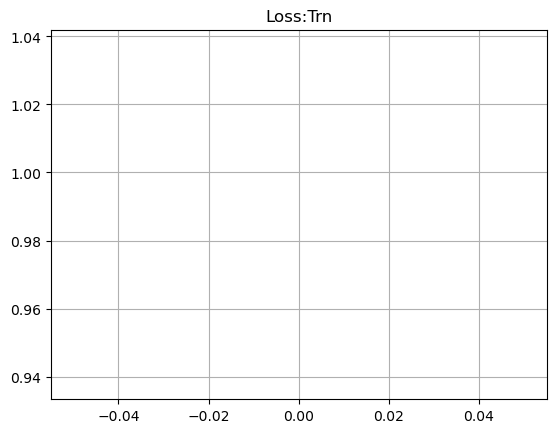

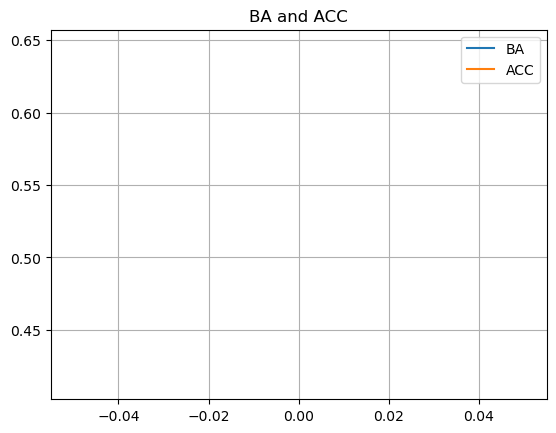

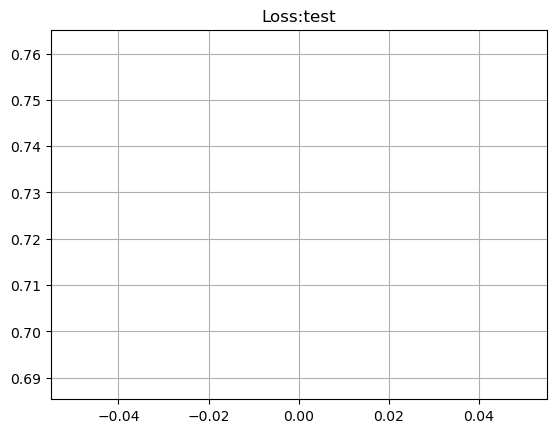

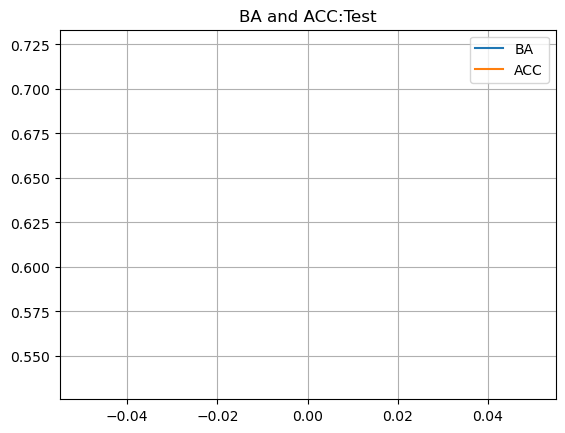

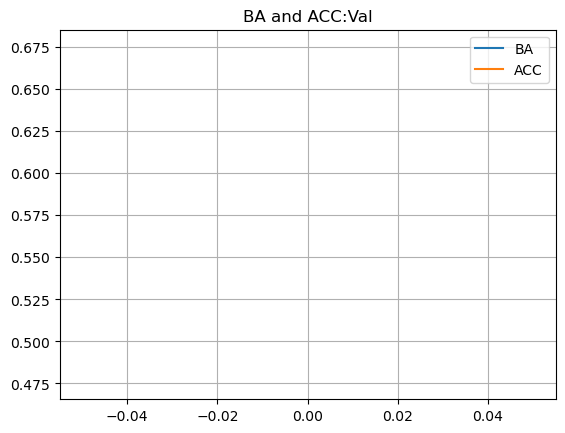

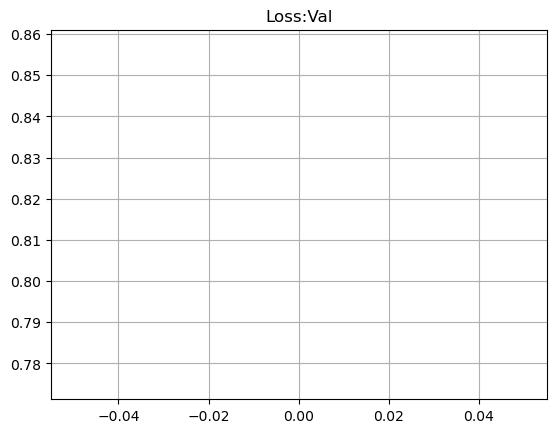

In [5]:
# Train loop
exp_base_dir = 'results_pad_5' #Change accordingly with each cross validation - stores training, validation, testing information
for model_id in range(5,6):
    #Select specific model type
    if model_id == 1:
        model = resnet_model().cuda()
    if model_id == 2:    
        model = resnet_concat_model().cuda()
    if model_id == 3:    
        model = resnet_metanet_model().cuda()
    if model_id == 4:
        model = resnet_metablock_model().cuda()
    if model_id == 5:
        model = meta_fusion_model().cuda()

    #Initialize optimizer, scheduler, number of epochs
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6) 
    start_epoch=0
    num_epochs = 1

    # Initialize lists to store epoch information
    model.cuda()
    loss_list =[]
    ba_list=[]
    acc_list=[]
    ba_test_list=[]
    acc_test_list=[]
    loss_test_list =[]
    ba_val_list=[]
    acc_val_list=[]
    loss_val_list =[]
    exp_dir = exp_base_dir + "\\exp_"+str(model_id)+"\\"
    
    if not os.path.exists(exp_dir):
        os.mkdir(exp_dir)
        
    for epoch in range(start_epoch,start_epoch+num_epochs):
        model.train() 
        #Call the train_one_epoch function 
        mean_loss, ba,acc = train_one_epoch(model, optimizer, scheduler, train_loader)          
        model_file_name = exp_dir + "resnet_model_epoch_"+str(epoch)+".pth"
        print("Saving model for epoch", epoch)
        torch.save(model.cpu().state_dict(), model_file_name)
        loss_list.append(mean_loss)
        ba_list.append(ba)
        acc_list.append(acc)
        model.cuda()
        ba, acc, loss = eval_model(model, val_loader)
        ba_val_list.append(ba)
        acc_val_list.append(acc)
        loss_val_list.append(loss)
        ba_test, acc_test, loss_test = eval_model(model, test_loader)
        ba_test_list.append(ba_test)
        acc_test_list.append(acc_test)
        loss_test_list.append(loss_test)
    write_results(exp_dir,loss_list, ba_list, acc_list, loss_val_list, ba_val_list, acc_val_list, loss_test_list, ba_test_list, acc_test_list)        
                


